In [17]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
from scipy.optimize import curve_fit

In [7]:
# Name of the file we want to read. 
# Remember, "Measurement.ttbin" files read all the files in sequence 'Measurement'
file = "ttbin_measurements/TimeTags_RaulAir_2024-10-25_172331.ttbin"

In [8]:
fr = FileReader(file)
print("All channels available: {}".format(fr.getChannelList()))

print("Has data? ->", fr.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

All channels available: (1, 2)
Has data? -> True


In [9]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2024-10-25 17:23:31 +0200
devices: [{'FPGA ID': 11493476189726804, 'PCB UID': '00fdf287', 'PCB version': '1.8 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '2410001ABQ'}]
firmware version: TT-Ultra, FW6, TS 2024-02-09 12:21:10, OK 1.46
fpga link: {'enabled': False}
hardware buffer size: 67108864
inputs: [{'average rising falling': [False, False], 'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [333, 333], 'high priority channel': [False, False], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 42.0, 'trigger level': 0.5}, {'average rising falling': [False, False], 'channel': [2, -2], 'conditional fi

In [10]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

{'configure version': 1,
 'current time': '2024-10-26 00:04:29 +0200',
 'hardware configuration': None,
 'measurements': [],
 'replay speed': -1.0,
 'software clock': None,
 'software version': '2.17.4',
 'virtual inputs': []}


Correlation measurement is running.

Rate of counts channel 1 (counts/sec) : 8003.999108212611
Total counts channel 1 : 19357524
Rate of counts channel 2 (counts/sec) : 4305.408941877971
Total counts channel 2 : 10412552


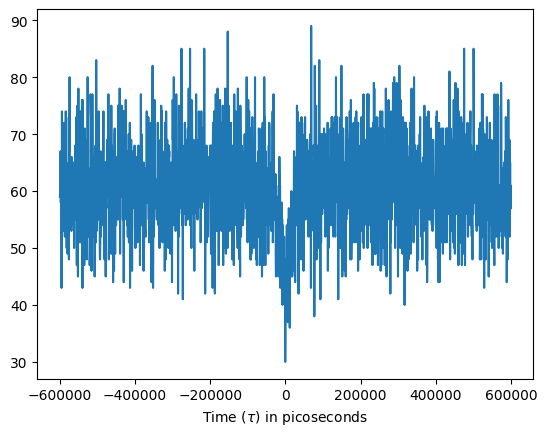

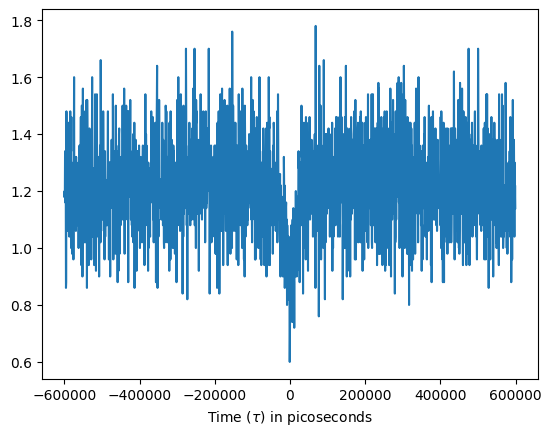

In [15]:
# measure photon antibunching
corr_ch1 = 1 # first photon channel for antibunching measurements
corr_ch2 = 2 # second photon channel for antibunching measurements
bwcorr = 600 # 1 ns
nbins = 2000

corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])
print("\nCorrelation measurement is running.\n")


virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
#virtual_tagger.replay(file, duration=8*10e11) # collect only 1 sec. of data (duration in picoseconds)
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr = corr.getIndex()
ycorr_norm = corr.getDataNormalized()
ycorr = corr.getData()

print(f"Rate of counts channel {corr_ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Total counts channel {corr_ch1} : {cr.getCountsTotal()[0]}")
print(f"Rate of counts channel {corr_ch2} (counts/sec) : {cr.getData()[1]}")
print(f"Total counts channel {corr_ch2} : {cr.getCountsTotal()[1]}")

plt.plot(xcorr, ycorr)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

plt.plot(xcorr, ycorr_norm)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

## Data analysis

In [13]:
# Function to plot the data
def plot_data(tau, counts, width=10, height=6):
    plt.figure(figsize=(width, height))
    plt.plot(tau, counts, marker='o', linestyle='-', color='b', markersize=3, linewidth=0.7)
    plt.title('Auto-correlation graph')
    plt.xlabel('Time differences (ps)')
    plt.ylabel('Counts per bin')
    plt.grid(True)
    plt.show()

In [14]:
# Function to plot normalized data
def plot_normalized_data(tau, counts, width=10, height=6):
    # Normalize counts by dividing by the mean
    counts_normalized = counts / np.mean(counts)
    
    plt.figure(figsize=(width, height))
    plt.plot(tau, counts_normalized, marker='o', linestyle='-', color='b', markersize=3, linewidth=0.7)
    plt.title('Normalized auto-correlation graph')
    plt.xlabel('Time differences (ps)')
    plt.ylabel('Normalized Counts')
    plt.grid(True)
    plt.show()

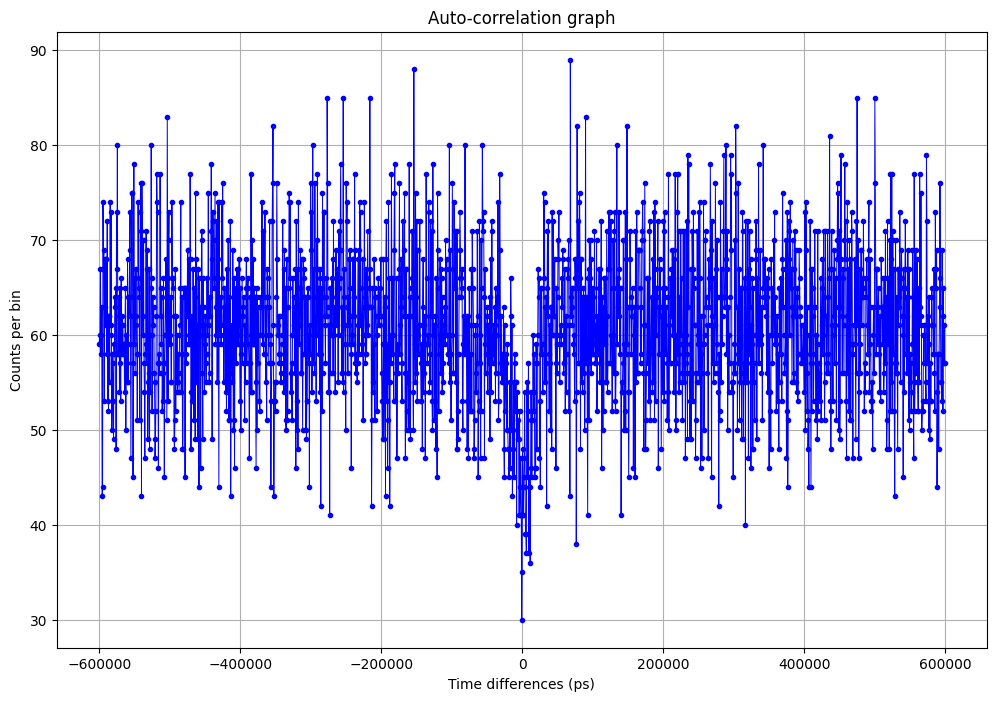

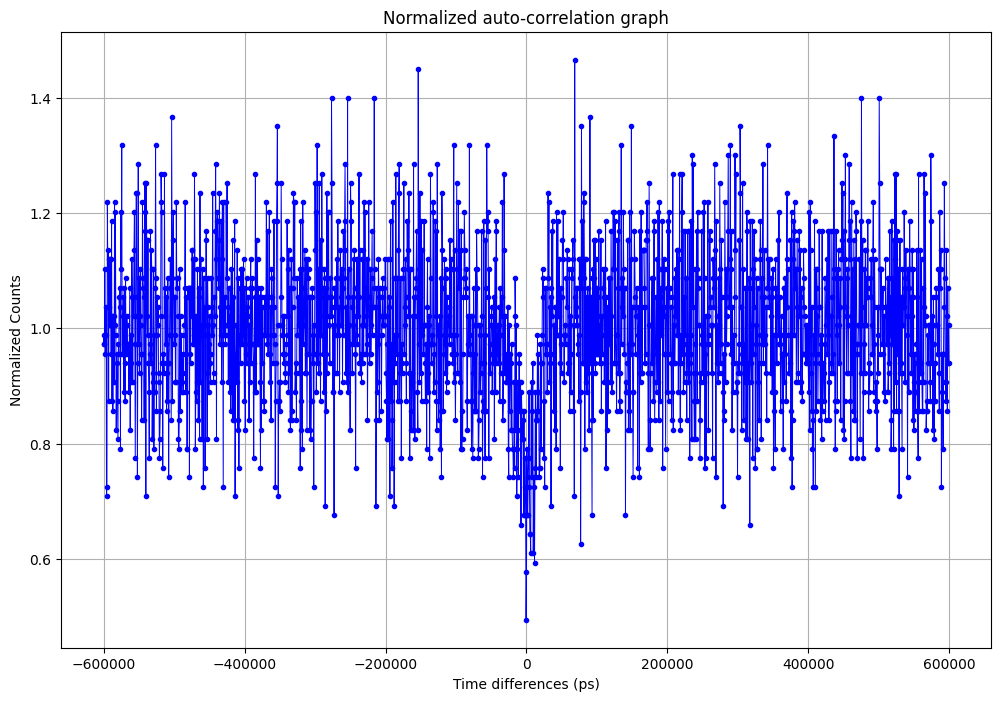

In [18]:
plot_data(xcorr, ycorr, width=12, height=8)
plot_normalized_data(xcorr, ycorr, width=12, height=8)

In [19]:

# Define the fitting function: 1 - C * exp(-2 * abs(tau - t0) / tau0)
def fitting_function(tau, t_0, tau_0, a, b):
    return a * (1 - b * np.exp(-2 * np.abs(tau - t_0) / tau_0))

# Function to normalize counts and fit the data
def normalize_and_fit(tau, counts):
    # Normalize counts by dividing by the mean
    counts_normalized = counts / np.mean(counts)
    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function, tau, counts_normalized, p0=[0, 1e5, 1, 1])
    
    # Extract fitted parameters
    t_0, tau_0, a, b = popt
    
    # Calculate the standard deviations of the parameters
    perr = np.sqrt(np.diag(pcov))
    error_t0, error_tau0, error_a, error_b = perr

    # Print fitted parameters and their errors
    print(f"Fitted parameters: t₀ = {t_0:.2f} ± {error_t0:.2f} ps")
    print(f"Lifetime = {tau_0 / 1000:.2f} ± {error_tau0 / 1000:.2f} ns")
    
    # Calculate g²(τ = t₀)
    value_at_t_0 = fitting_function(t_0, t_0, tau_0, a, b)
    error_value_at_t_0 = np.sqrt(error_a**2 + error_b**2)  # Estimate error propagation
    print(f"g²(τ = t₀) = {value_at_t_0:.3f} ± {error_value_at_t_0:.3f}")
    
    return t_0, tau_0, a, b, counts_normalized

# Function to plot the normalized data and the fitted curve
def plot_fit(tau, counts_normalized, t_0, tau_0, a, b, width=10, height=6):
    # Create the plot
    plt.figure(figsize=(width, height))
    
    # Plot normalized data
    plt.plot(tau, counts_normalized, marker='o', linestyle='-', color='b', label='Normalized Data', markersize=3, linewidth=0.7)
    plt.title('Normalized auto-correlation graph')
    
    # Generate the fitted curve
    tau_fine = np.linspace(min(tau), max(tau), 10000)
    fitted_curve = fitting_function(tau_fine, t_0, tau_0, a, b)
    
    # Plot fitted curve
    plt.plot(tau_fine, fitted_curve, 'r-', label=f'Fit: t₀={t_0:.2f}, τ₀={tau_0:.2f}')
    
    # Add title and labels
    plt.title('Normalized auto-correlation graph with fitted curve')
    plt.xlabel('Time differences (ps)')
    plt.ylabel('Normalized Counts')
    plt.legend()
    plt.grid(True)
    plt.show()


Fitted parameters: t₀ = 300.78 ± 1062.40 ps
Lifetime = 29.72 ± 4.37 ns
g²(τ = t₀) = 0.648 ± 0.036


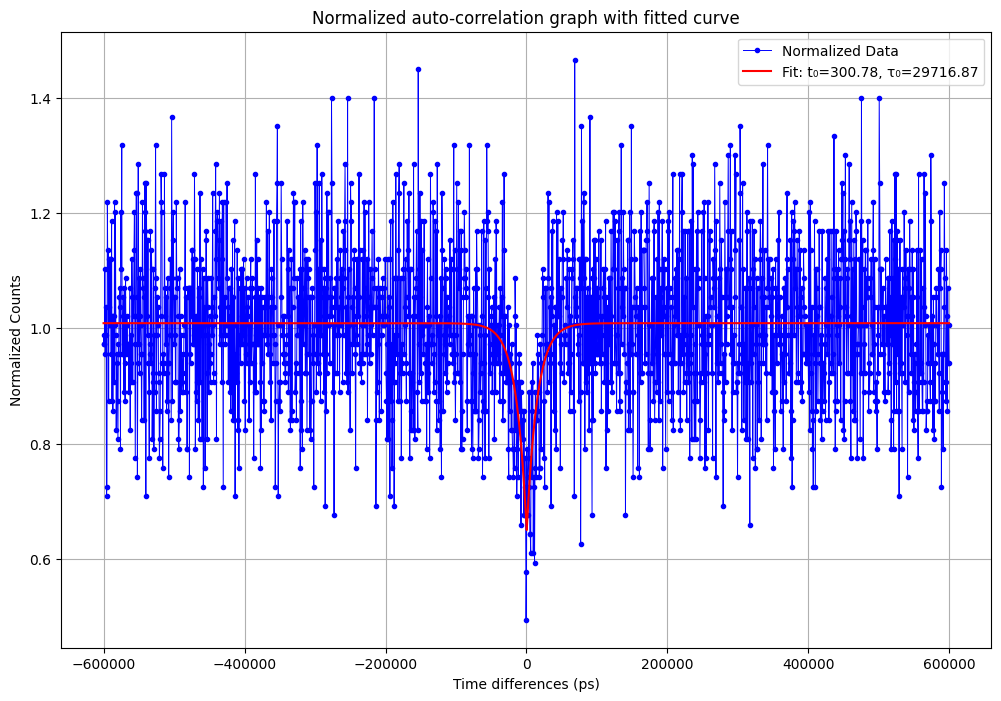

In [20]:
# Normalize and fit the data
t_0, tau_0, a, b, counts_normalized = normalize_and_fit(xcorr, ycorr)

# Plot the normalized data and the fitted curve
plot_fit(xcorr, counts_normalized, t_0, tau_0, a, b, width=12, height=8)